This notebook contains Helen's code for analyzing the fully joined FEC/DCInbox data.

In [207]:
# KEEP
# import libraries
import pandas as pd
import numpy as np
# import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [169]:
# Read in the joined all dataset

joined_all_df = pd.read_csv(
#     "../data/dcinbox/dcinbox_export_119th_through9_19_2025.csv",
    "../data/matched/joined_all_2020_test.csv",
    # sep = ",",            # columns are separated by commas
    encoding = "latin1",
    quotechar = '"',   # Make sure actual quotation marks in newsletters are handled right
    engine = 'python'    # This might be able to handle very long messages better,
    # names = column_names
)

# Create a binary column to show whether fundraising terms appear in the newsletter
joined_all_df["fundraising_terms_used"] = joined_all_df["fundraising_terms_sum"] > 0

# create a contribution year column
joined_all_df["contrib_date"] = pd.to_datetime(joined_all_df["contrib_date"], errors="coerce")
joined_all_df["contrib_year"] = joined_all_df["contrib_date"].dt.year

print(len(joined_all_df))
joined_all_df.head()
# joined_all_df.columns

25785


,dc_name,dc_date,newsletter_count,body_word_count_sum,fundraising_terms_sum,fundraising_ratio_mean,total_newsletters,dc_congress,dc_gender,dc_state,...,window_contrib_count,window_contrib_amount,avg_daily_fp_count_score,avg_daily_fp_amount_score,month_daily_count_score,month_daily_amount_score,avg_daily_td_count_score,avg_daily_td_amount_score,fundraising_terms_used,contrib_year
0,A. FERGUSON,2019-01-13,1,357,0,0.000000,44,116,M,GA,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN
1,A. FERGUSON,2019-01-27,1,528,0,0.000000,44,116,M,GA,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN
2,A. FERGUSON,2019-02-10,1,457,0,0.000000,44,116,M,GA,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,NaN
3,A. FERGUSON,2019-03-03,1,430,1,0.002326,44,116,M,GA,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN
4,A. FERGUSON,2019-03-17,1,271,1,0.003690,44,116,M,GA,...,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,NaN


In [170]:
# Read in the summarized FEC candidate contributions file

# column_names = ["target_id", "dcinbox_name", "fec_cid", "fec_name",
#                 "fec_party", "fec_state", "fec_district",
#                 "fec_cycle", "append_attribute2", "append_attribute3",
#                 "similarity_score", "matched_scorer"]

cand_contribs_raw_df = pd.read_csv(
    "../data/fec/candidate_contributions_2020_test.csv",
    encoding = "latin1",
    # quotechar = '"',   # Make sure actual quotation marks are handled right
    # names = column_names,
    # header = 0
)

# Drop the columns we don't need
cand_contribs_raw_df = cand_contribs_raw_df.drop(columns=['DistIDRunFor', 'DistIDCurr', "CurrCand", "CycleCand", 
                                                  "RecipCode", "CRPICO", "FECCandID"])

print(len(cand_contribs_raw_df))
cand_contribs_raw_df.head()

122459


,Cycle,CID,FirstLastP,Party Original,NoPacs,State,District,Party,contrib_date,contrib_count,contrib_amount
0,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-01-10,1,2500.0
1,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-02-25,1,500.0
2,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-02-28,2,750.0
3,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-03-14,2,1000.0
4,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-03-28,1,500.0


In [171]:
# Clean up columns in the summarized FEC candidate contributions dataframe

# Rename columns so they won't clash with the DC Inbox data file
cand_contribs_df = cand_contribs_raw_df.rename(columns={
    "Cycle": "fec_cycle",
    "CID": "fec_cid",
    "FirstLastP": "fec_name",
    "Party Original": "fec_party_original",
    "NoPacs": "no_pacs",
    "State": "fec_state",
    "District": "fec_district",
    "Party": "fec_party"    
})

# Set correct types on some columns
cand_contribs_df["contrib_count"] = cand_contribs_df["contrib_count"].fillna(0)
cand_contribs_df["contrib_amount"] = cand_contribs_df["contrib_amount"].fillna(0).astype(int)

cand_contribs_df.head()

,fec_cycle,fec_cid,fec_name,fec_party_original,no_pacs,fec_state,fec_district,fec_party,contrib_date,contrib_count,contrib_amount
0,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-01-10,1,2500
1,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-02-25,1,500
2,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-02-28,2,750
3,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-03-14,2,1000
4,2020,N00030768,MARTHA ROBY,R,,AL,2,R,2019-03-28,1,500


In [172]:
# Add US Census region to joined_all_df dataframe
# From https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

# Define US Census regions by state
census_regions = {
    # Northeast
    "CT": "Northeast", "ME": "Northeast", "MA": "Northeast", "NH": "Northeast",
    "RI": "Northeast", "VT": "Northeast", "NJ": "Northeast", "NY": "Northeast",
    "PA": "Northeast",
    
    # Midwest
    "IN": "Midwest", "IL": "Midwest", "MI": "Midwest", "OH": "Midwest", "WI": "Midwest",
    "IA": "Midwest", "KS": "Midwest", "MN": "Midwest", "MO": "Midwest", "NE": "Midwest",
    "ND": "Midwest", "SD": "Midwest",
    
    # South
    "DE": "South", "FL": "South", "GA": "South", "MD": "South", "NC": "South",
    "SC": "South", "VA": "South", "DC": "South", "WV": "South", "AL": "South",
    "KY": "South", "MS": "South", "TN": "South", "AR": "South", "LA": "South",
    "OK": "South", "TX": "South",
    
    # West
    "AZ": "West", "CO": "West", "ID": "West", "MT": "West", "NV": "West", "NM": "West",
    "UT": "West", "WY": "West", "AK": "West", "CA": "West", "HI": "West", "OR": "West",
    "WA": "West"
}

# Map dc_state to census_region
joined_all_df["census_region"] = joined_all_df["dc_state"].map(census_regions)

# Optional: fill any unmapped values with 'Unknown'
joined_all_df["census_region"] = joined_all_df["census_region"].fillna("Unknown")

# Check results
# Group by census_region and print the unique states in each region
states_by_region = joined_all_df.groupby("census_region")["dc_state"].unique()
for region, states in states_by_region.items():
    print(f"{region}: {', '.join(states)}")

Midwest: IA, IL, NE, IN, MI, MN, MO, OH, WI, SD, ND, KS
Northeast: NY, NJ, NH, MA, PA, ME, RI, CT, VT
South: GA, VA, TX, FL, WV, NC, MD, AL, KY, AR, LA, TN, DC, OK, SC, DE, MS
Unknown: AS, MP, GU, VI
West: CA, WA, AZ, NM, UT, CO, NV, AK, OR, HI, MT, WY, ID


In [173]:
# Create a version of the joined all dataframe with only D & R records
# and setting all score columns to 0 if date is NA

# Print original number of rows
print(len(joined_all_df))

# Ensure date and numeric fields are usable
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"], errors="coerce")
joined_all_df["contrib_date"] = pd.to_datetime(joined_all_df["contrib_date"], errors="coerce")

# Pull only D and R records
joined_score_df = joined_all_df[joined_all_df["dc_party"].isin(["D", "R"])].copy()

# Ensure score columns are numeric
score_cols = ["month_daily_amount_score", "avg_daily_fp_amount_score", "avg_daily_td_amount_score"]
for col in score_cols:
    joined_score_df[col] = pd.to_numeric(joined_score_df[col], errors="coerce")

# Set score columns to 0 where dc_date is NaT or NaN
mask_no_date = joined_score_df["dc_date"].isna()
joined_score_df.loc[mask_no_date, score_cols] = 0

# Remove rows where contrib_date is NaN (if still needed)
# joined_score_df = joined_score_df[joined_score_df["contrib_date"].notna()].copy()

print(len(joined_score_df))

25785
25777


In [174]:
# Basic contributions stats

# (a) Total contribution amount
total_contrib_amount = cand_contribs_df["contrib_amount"].sum()

# (b) Total for Democrats
total_contrib_amount_D = cand_contribs_df.loc[cand_contribs_df["fec_party"] == "D", "contrib_amount"].sum()

# (c) Total for Republicans
total_contrib_amount_R = cand_contribs_df.loc[cand_contribs_df["fec_party"] == "R", "contrib_amount"].sum()

# (d) Overall average contribution (total $ / total count)
overall_avg_contrib = cand_contribs_df["contrib_amount"].sum() / cand_contribs_df["contrib_count"].sum()

# (e) Average contribution for Democrats
avg_contrib_D = (
    cand_contribs_df.loc[cand_contribs_df["fec_party"] == "D", "contrib_amount"].sum() /
    cand_contribs_df.loc[cand_contribs_df["fec_party"] == "D", "contrib_count"].sum()
)

# (f) Average contribution for Republicans
avg_contrib_R = (
    cand_contribs_df.loc[cand_contribs_df["fec_party"] == "R", "contrib_amount"].sum() /
    cand_contribs_df.loc[cand_contribs_df["fec_party"] == "R", "contrib_count"].sum()
)

# Print results neatly
print(f"Total contributions in period (all): ${total_contrib_amount:,.0f}")
print(f"Total contributions in period (Democrats): ${total_contrib_amount_D:,.0f}")
print(f"Total contributions in period (Republicans): ${total_contrib_amount_R:,.0f}")
print()
print(f"Average contribution in period (all): ${overall_avg_contrib:,.2f}")
print(f"Average contribution in period (Democrats): ${avg_contrib_D:,.2f}")
print(f"Average contribution in period (Republicans): ${avg_contrib_R:,.2f}")

Total contributions in period (all): $594,500,449
Total contributions in period (Democrats): $400,939,404
Total contributions in period (Republicans): $192,897,179

Average contribution in period (all): $300.16
Average contribution in period (Democrats): $383.93
Average contribution in period (Republicans): $206.28


In [175]:
# Basic DC Inbox stats

# Total newsletters sent
total_politicians = joined_all_df["dc_name"].nunique()

# Total newsletters sent
total_newsletters = joined_all_df["newsletter_count"].sum()

# Total for Democrats
total_newsletters_D = joined_all_df.loc[joined_all_df["dc_party"] == "D", "newsletter_count"].sum()

# Total for Republicans
total_newsletters_R = joined_all_df.loc[joined_all_df["dc_party"] == "R", "newsletter_count"].sum()

# Newsletters sent per politician (total sent / total politicians)
newsletters_per_pol = joined_all_df["newsletter_count"].sum() / joined_all_df["dc_name"].nunique()

# newsletters per politician for Democrats
newsletters_per_pol_D = (
    joined_all_df.loc[joined_all_df["dc_party"] == "D", "newsletter_count"].sum() /
    joined_all_df.loc[joined_all_df["dc_party"] == "D", "dc_name"].nunique()
)

# newsletters per politician for Republicans
newsletters_per_pol_R = (
    joined_all_df.loc[joined_all_df["dc_party"] == "R", "newsletter_count"].sum() /
    joined_all_df.loc[joined_all_df["dc_party"] == "R", "dc_name"].nunique()
)

# Make sure contrib_date or newsletter date is datetime
joined_all_df["contrib_date"] = pd.to_datetime(joined_all_df["contrib_date"], errors="coerce")

# Compute total number of days in dataset
date_range_days = (joined_all_df["contrib_date"].max() - joined_all_df["contrib_date"].min()).days + 1

# Average daily newsletters per politician (overall and by party)
avg_daily_per_pol = total_newsletters / (joined_all_df["dc_name"].nunique() * date_range_days)
avg_daily_per_pol_D = total_newsletters_D / (
    joined_all_df.loc[joined_all_df["dc_party"] == "D", "dc_name"].nunique() * date_range_days
)
avg_daily_per_pol_R = total_newsletters_R / (
    joined_all_df.loc[joined_all_df["dc_party"] == "R", "dc_name"].nunique() * date_range_days
)

# Print results neatly
print(f"Number of politicians sending newsletters: {total_politicians:,.0f}")
print()
print(f"Newsletters sent: {total_newsletters:,.0f}")
print(f"Newsletters sent (Democrats): {total_newsletters_D:,.0f}")
print(f"Newsletters sent (Republicans): {total_newsletters_R:,.0f}")
print()
print(f"Average newsletters per politician: {newsletters_per_pol:,.0f}")
print(f"Average newsletters per politician (Democrats): {newsletters_per_pol_D:,.0f}")
print(f"Average newsletters per politician (Republicans): {newsletters_per_pol_R:,.0f}")
print()
print(f"Average daily newsletters per politician (overall): {avg_daily_per_pol:.3f}")
print(f"Average daily newsletters per politician (Democrats): {avg_daily_per_pol_D:.3f}")
print(f"Average daily newsletters per politician (Republicans): {avg_daily_per_pol_R:.3f}")


Number of politicians sending newsletters: 426

Newsletters sent: 26,731
Newsletters sent (Democrats): 12,986
Newsletters sent (Republicans): 13,737

Average newsletters per politician: 63
Average newsletters per politician (Democrats): 56
Average newsletters per politician (Republicans): 70

Average daily newsletters per politician (overall): 0.086
Average daily newsletters per politician (Democrats): 0.077
Average daily newsletters per politician (Republicans): 0.097


In [176]:
# Basic combo stats from the joined data table

# Count total rows
total = len(joined_all_df)

# Count rows with window_contrib_amount = 0
zero_count = (joined_all_df["window_contrib_amount"] == 0).sum()

# Count rows with window_contrib_amount > 0
positive_count = (joined_all_df["window_contrib_amount"] > 0).sum()

# Sum up contribution amounts
window_contrib_amt_total = joined_all_df["window_contrib_amount"].sum()
window_contrib_r = joined_all_df.loc[joined_all_df["dc_party"] == "R", "window_contrib_amount"].sum()
window_contrib_d = joined_all_df.loc[joined_all_df["dc_party"] == "D", "window_contrib_amount"].sum()

# Calculate percentages
zero_pct = zero_count / total * 100
positive_pct = positive_count / total * 100

print(f"Percent of all newsletters with contributions in the window after they were sent: {positive_pct:.1f}%")
print(f"Percent of all newsletters with no contributions in the window after they were sent: {zero_pct:.1f}%\n")
print(f"Sum of the contributions that came in during the newsletter windows: ${window_contrib_amt_total:,.0f}")
print(f"  • Window contribution amount (Democrats): ${window_contrib_d:,.0f}")
print(f"  • Window contribution amount (Republicans): ${window_contrib_r:,.0f}")
print()


Percent of all newsletters with contributions in the window after they were sent: 39.6%
Percent of all newsletters with no contributions in the window after they were sent: 59.9%

Sum of the contributions that came in during the newsletter windows: $122,754,844
  • Window contribution amount (Democrats): $80,335,571
  • Window contribution amount (Republicans): $42,419,273



In [177]:
# Basic averages from the joined data table

# --- (a) Average window contribution amounts by fundraising terms ---
avg_contrib_with_terms = joined_all_df.loc[joined_all_df["fundraising_terms_sum"] > 0, "window_contrib_amount"].mean()
avg_contrib_without_terms = joined_all_df.loc[joined_all_df["fundraising_terms_sum"] == 0, "window_contrib_amount"].mean()

print("Average window contribution amount by fundraising mention:")
print(f"  • Mentions fundraising terms: ${avg_contrib_with_terms:,.0f}")
print(f"  • Does NOT mention fundraising terms: ${avg_contrib_without_terms:,.0f}")
print()

# --- (b) Average window contribution amounts by newsletter length ---
avg_contrib_short = joined_all_df.loc[joined_all_df["body_word_count_sum"] < 500, "window_contrib_amount"].mean()
avg_contrib_long = joined_all_df.loc[joined_all_df["body_word_count_sum"] >= 500, "window_contrib_amount"].mean()

print("Average window contribution amount by newsletter length:")
print(f"  • Short newsletters (< 500 words): ${avg_contrib_short:,.0f}")
print(f"  • Long newsletters (≥ 500 words): ${avg_contrib_long:,.0f}")
print()

# --- (c) Average window contribution amounts per politician ---
total_per_pol = window_contrib_amt_total / joined_all_df["dc_name"].nunique()
d_per_pol = window_contrib_d / joined_all_df.loc[joined_all_df["dc_party"] == "D", "dc_name"].nunique()
r_per_pol = window_contrib_r / joined_all_df.loc[joined_all_df["dc_party"] == "R", "dc_name"].nunique()

print("Average total window contribution amount per politician:")
print(f"  • Overall: ${total_per_pol:,.0f}")
print(f"  • Democrats: ${d_per_pol:,.0f}")
print(f"  • Republicans: ${r_per_pol:,.0f}")
print()

# --- (d) Average window contribution amounts per politician by gender ---
if "dc_gender" in joined_all_df.columns:
    total_gender_amt = joined_all_df.groupby("dc_gender")["window_contrib_amount"].sum()
    total_gender_count = joined_all_df.groupby("dc_gender")["dc_name"].nunique()

    avg_per_pol_total = window_contrib_amt_total / joined_all_df["dc_name"].nunique()
    avg_per_pol_m = total_gender_amt.get("M", 0) / total_gender_count.get("M", 1)
    avg_per_pol_f = total_gender_amt.get("F", 0) / total_gender_count.get("F", 1)

    print("Average total window contribution amount per politician by gender:")
    print(f"  • Overall: ${avg_per_pol_total:,.0f}")
    print(f"  • Male politicians: ${avg_per_pol_m:,.0f}")
    print(f"  • Female politicians: ${avg_per_pol_f:,.0f}")
else:
    print("Column 'dc_gender' not found — skipping gender-based summary.")


Average window contribution amount by fundraising mention:
  • Mentions fundraising terms: $4,400
  • Does NOT mention fundraising terms: $5,375

Average window contribution amount by newsletter length:
  • Short newsletters (< 500 words): $5,774
  • Long newsletters (≥ 500 words): $4,134

Average total window contribution amount per politician:
  • Overall: $288,157
  • Democrats: $349,285
  • Republicans: $217,535

Average total window contribution amount per politician by gender:
  • Overall: $288,157
  • Male politicians: $239,887
  • Female politicians: $439,528


In [194]:
# Basic medians from the joined all data frame

# --- (a2) Median window contribution amounts by fundraising terms ---
med_contrib_with_terms = joined_all_df.loc[joined_all_df["fundraising_terms_sum"] > 0, "window_contrib_amount"].median()
med_contrib_without_terms = joined_all_df.loc[joined_all_df["fundraising_terms_sum"] == 0, "window_contrib_amount"].median()

# print("Median window contribution amount by fundraising mention:")
# print(f"  • Mentions fundraising terms: ${med_contrib_with_terms:,.0f}")
# print(f"  • Does NOT mention fundraising terms: ${med_contrib_without_terms:,.0f}")
# print()

# --- (b2) Median window contribution amounts by newsletter length ---
med_contrib_short = joined_all_df.loc[joined_all_df["body_word_count_sum"] < 500, "window_contrib_amount"].median()
med_contrib_long = joined_all_df.loc[joined_all_df["body_word_count_sum"] >= 500, "window_contrib_amount"].median()

# print("Median window contribution amount by newsletter length:")
# print(f"  • Short newsletters (< 500 words): ${med_contrib_short:,.0f}")
# print(f"  • Long newsletters (≥ 500 words): ${med_contrib_long:,.0f}")
# print()

# --- (c2) Median window contribution amounts per politician ---
median_per_pol = joined_all_df.groupby("dc_name")["window_contrib_amount"].sum().median()
median_per_pol_d = (
    joined_all_df.loc[joined_all_df["dc_party"] == "D"]
    .groupby("dc_name")["window_contrib_amount"].sum().median()
)
median_per_pol_r = (
    joined_all_df.loc[joined_all_df["dc_party"] == "R"]
    .groupby("dc_name")["window_contrib_amount"].sum().median()
)

print("Median total window contribution amount per politician:")
print(f"  • Overall: ${median_per_pol:,.0f}")
print(f"  • Democrats: ${median_per_pol_d:,.0f}")
print(f"  • Republicans: ${median_per_pol_r:,.0f}")
print()

# --- (d2) Median window contribution amounts per politician by gender ---
if "dc_gender" in joined_all_df.columns:
    median_gender = (
        joined_all_df.groupby(["dc_gender", "dc_name"])["window_contrib_amount"]
        .sum()
        .groupby("dc_gender")
        .median()
    )

    median_per_pol_total = (
        joined_all_df.groupby("dc_name")["window_contrib_amount"].sum().median()
    )

    print("Median total window contribution amount per politician by gender:")
    # print(f"  • Overall: ${median_per_pol_total:,.0f}")
    print(f"  • Male politicians: ${median_gender.get('M', 0):,.0f}")
    print(f"  • Female politicians: ${median_gender.get('F', 0):,.0f}")
else:
    print("Column 'dc_gender' not found — skipping gender-based summary.")

# --- (e2) Median window contribution amounts per politician by census region ---
if "census_region" in joined_all_df.columns:
    print()
    median_region = (
        joined_all_df.groupby(["census_region", "dc_name"])["window_contrib_amount"]
        .sum()                       # total per politician
        .groupby("census_region")    # then by region
        .median()                    # median across politicians in that region
    )

    median_per_pol_total = (
        joined_all_df.groupby("dc_name")["window_contrib_amount"].sum().median()
    )

    print("Median total window contribution amount per politician by census region:")
    # print(f"  • Overall: ${median_per_pol_total:,.0f}")
    for region in ["Northeast", "Midwest", "South", "West"]:
        print(f"  • {region}: ${median_region.get(region, 0):,.0f}")
else:
    print("Column 'census_region' not found — skipping region-based summary.")

# --- (f2) Median window contribution amounts per politician by census region AND party ---
if "census_region" in joined_all_df.columns:
    print()
    print("Median total window contribution amount per politician by census region and party:")

    # Loop through each region
    for region in ["Northeast", "Midwest", "South", "West"]:
        # Democrats
        median_dem = (
            joined_all_df.loc[
                (joined_all_df["census_region"] == region) & (joined_all_df["dc_party"] == "D")
            ]
            .groupby("dc_name")["window_contrib_amount"]
            .sum()
            .median()
        )
        # Republicans
        median_rep = (
            joined_all_df.loc[
                (joined_all_df["census_region"] == region) & (joined_all_df["dc_party"] == "R")
            ]
            .groupby("dc_name")["window_contrib_amount"]
            .sum()
            .median()
        )

        print(f"  • {region}: Democrats ${median_dem:,.0f}, Republicans ${median_rep:,.0f}")
else:
    print("Column 'census_region' not found — skipping region-and-party-based summary.")

Median total window contribution amount per politician:
  • Overall: $66,887
  • Democrats: $94,476
  • Republicans: $47,498

Median total window contribution amount per politician by gender:
  • Male politicians: $57,050
  • Female politicians: $161,172

Median total window contribution amount per politician by census region:
  • Northeast: $106,641
  • Midwest: $87,316
  • South: $47,975
  • West: $76,765

Median total window contribution amount per politician by census region and party:
  • Northeast: Democrats $105,383, Republicans $108,339
  • Midwest: Democrats $137,042, Republicans $68,894
  • South: Democrats $87,452, Republicans $43,985
  • West: Democrats $110,580, Republicans $39,526


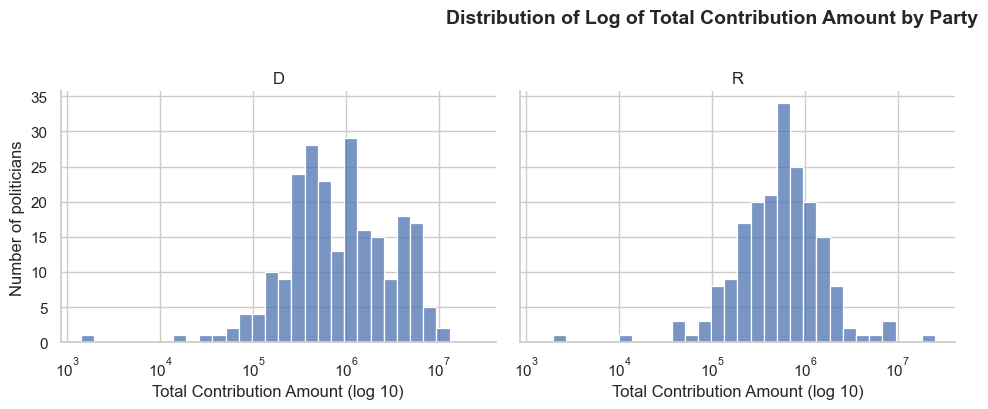

In [179]:
# Distribution of total contribution amounts by party

# Remove third parties
no_third_party = True

# Aggregate to total contributions per politician
agg_df = (
    cand_contribs_df
    .groupby(["fec_cid", "fec_party"], as_index=False)
    ["contrib_amount"].sum()
)

if no_third_party:
    agg_df = agg_df[agg_df["fec_party"].isin(["D", "R"])].copy()

# Map better party titles
party_labels = {"D": "Democrats", "R": "Republicans", "O": "Other"}
agg_df["fec_party_label"] = agg_df["fec_party"].map(party_labels)

# Plot faceted histograms (log-scaled)
sns.set(style="whitegrid")

g = sns.displot(
    data=agg_df,
    x="contrib_amount",
    col="fec_party",
    bins=30,
    col_wrap=3,
    height=4,
    aspect=1.2,
    log_scale=True,   # <-- log the x-axis directly
    color=None
)

# Add titles and axis labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Total Contribution Amount (log 10)", "Number of politicians")
g.fig.suptitle(
    "Distribution of Log of Total Contribution Amount by Party",
    fontsize=14,
    fontweight="bold",
    ha="center",
    x = 0.5,
    y=1.02  # raises the title slightly above the facets
)

plt.tight_layout()
plt.show()


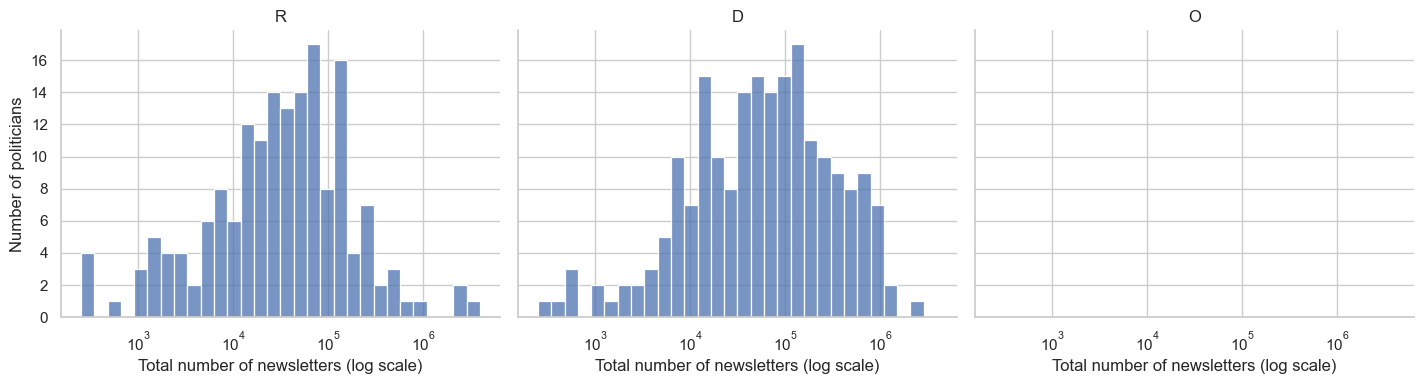

In [180]:
# Distribution of total newsletters by party

# Aggregate to total newsletters per politician
agg_df = (
    joined_all_df
    .groupby(["dc_name", "dc_party"], as_index=False)
    ["contrib_amount"].sum()
)

# Plot faceted histograms (log-scaled)
sns.set(style="whitegrid")

g = sns.displot(
    data=agg_df,
    x="contrib_amount",
    col="dc_party",
    bins=30,
    col_wrap=3,
    height=4,
    aspect=1.2,
    log_scale=True,   # <-- log the x-axis directly
    color=None
)

# Add titles and axis labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Total number of newsletters (log scale)", "Number of politicians")

plt.tight_layout()
plt.show()


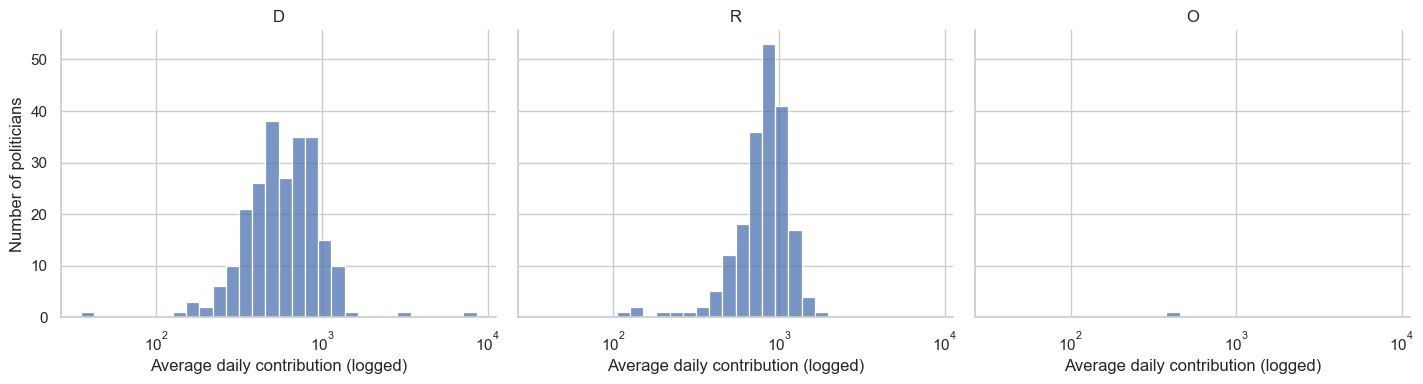

In [186]:
# Distribution of average daily contribution by party

cand_contribs_df["avg_daily_contrib_amount"] = cand_contribs_df["contrib_amount"] / cand_contribs_df["contrib_count"]

# Aggregate average daily contribution per politician
agg_df = (
    cand_contribs_df
    .groupby(["fec_cid", "fec_party"], as_index=False)
    ["avg_daily_contrib_amount"].mean()
)

# Plot faceted histograms (log-scaled)
sns.set(style="whitegrid")

g = sns.displot(
    data=agg_df,
    x="avg_daily_contrib_amount",
    col="fec_party",
    bins=30,
    col_wrap=3,
    height=4,
    aspect=1.2,
    log_scale=True,   # <-- log the x-axis directly
    color=None
)

# Add titles and axis labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Average daily contribution (logged)", "Number of politicians")

plt.tight_layout()
plt.show()


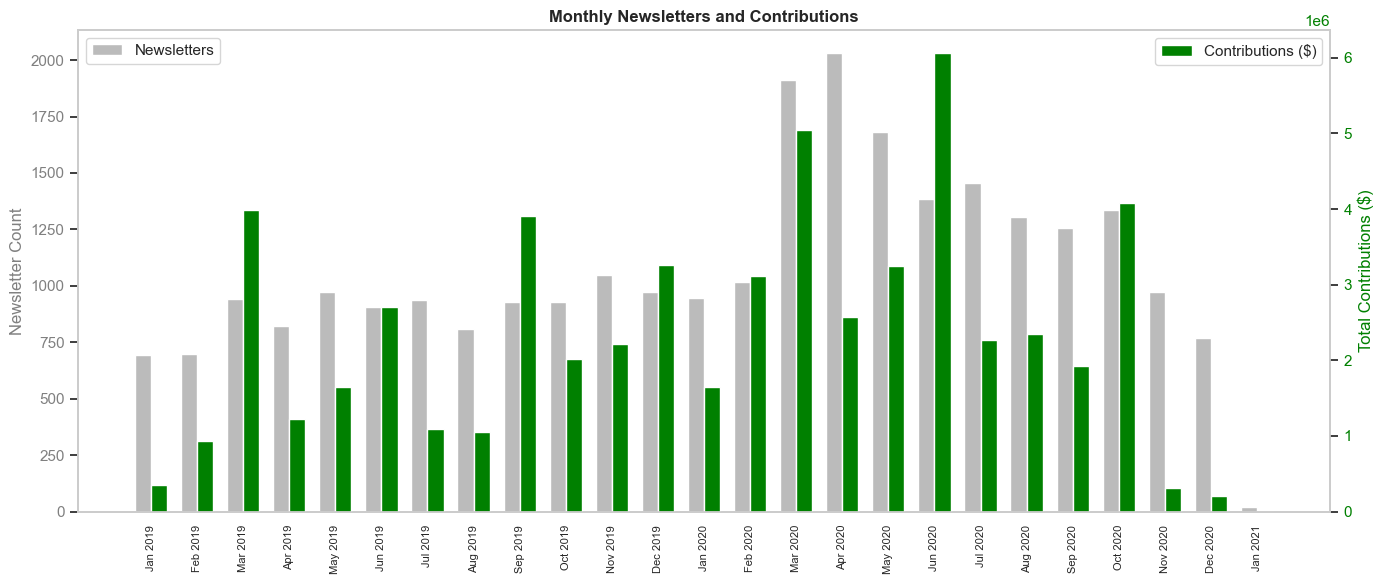

In [ ]:
# Ensure dc_date is datetime
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Create month-year column
joined_all_df["month_year"] = joined_all_df["dc_date"].dt.to_period("M").dt.to_timestamp()

# Aggregate totals per month
monthly_totals = (
    joined_all_df.groupby("month_year", as_index=False)
    .agg(
        total_newsletters=("newsletter_count", "sum"),
        total_contributions=("contrib_amount", "sum")
    )
)

# Numeric x positions
x = np.arange(len(monthly_totals))

# Width of bars
width = 0.35

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Left bars: newsletters
bars1 = ax1.bar(
    x - width/2,
    monthly_totals["total_newsletters"],
    width=width,
    color="#bbbbbb",
    label="Newsletters"
)
ax1.set_ylabel("Newsletter Count", color="gray")
ax1.tick_params(axis='y', labelcolor="gray")

# Right bars: contributions (on twin y-axis)
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    monthly_totals["total_contributions"],
    width=width,
    color="green",
    label="Contributions ($)"
)
ax2.set_ylabel("Total Contributions ($)", color="green")
ax2.tick_params(axis='y', labelcolor="green")

# Format x-axis
ax1.set_xticks(x)
ax1.set_xticklabels(monthly_totals["month_year"].dt.strftime("%b %Y"), rotation=90, fontsize=8)

# Title
plt.title("Monthly Newsletters and Contributions", fontweight="bold")

# Turn off gridlines
ax1.grid(False)
ax2.grid(False)

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

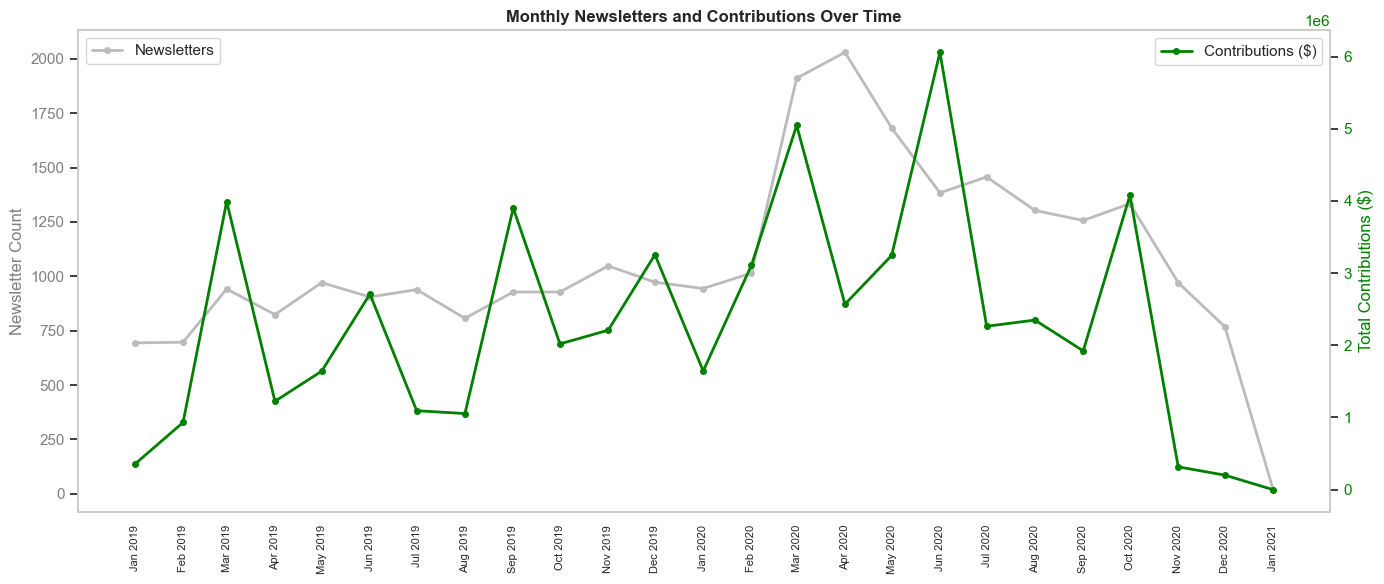

In [ ]:
# Ensure dc_date is datetime
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Create month-year column
joined_all_df["month_year"] = joined_all_df["dc_date"].dt.to_period("M").dt.to_timestamp()

# Aggregate totals per month
monthly_totals = (
    joined_all_df.groupby("month_year", as_index=False)
    .agg(
        total_newsletters=("newsletter_count", "sum"),
        total_contributions=("contrib_amount", "sum")
    )
)

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot newsletters on left y-axis
ax1.plot(
    monthly_totals["month_year"],
    monthly_totals["total_newsletters"],
    color="#bbbbbb",
    marker="o",
    markersize=4,       # smaller dots
    linewidth=2,        # wider line
    label="Newsletters"
)
ax1.set_ylabel("Newsletter Count", color="gray")
ax1.tick_params(axis="y", labelcolor="gray")

# Create twin y-axis for contributions
ax2 = ax1.twinx()
ax2.plot(
    monthly_totals["month_year"],
    monthly_totals["total_contributions"],
    color="green",
    marker="o",
    markersize=4,       # smaller dots
    linewidth=2,        # wider line
    label="Contributions ($)"
)
ax2.set_ylabel("Total Contributions ($)", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Format x-axis as "Jan 2020"
ax1.set_xticks(monthly_totals["month_year"])
ax1.set_xticklabels(monthly_totals["month_year"].dt.strftime("%b %Y"), rotation=90, fontsize=8)

# Title
plt.title("Monthly Newsletters and Contributions Over Time", fontweight="bold")

# Legends
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Turn off gridlines
ax1.grid(False)
ax2.grid(False)

plt.tight_layout()
plt.show()

C:\Users\hefla\AppData\Local\Temp\ipykernel_9852\3329775753.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="center")


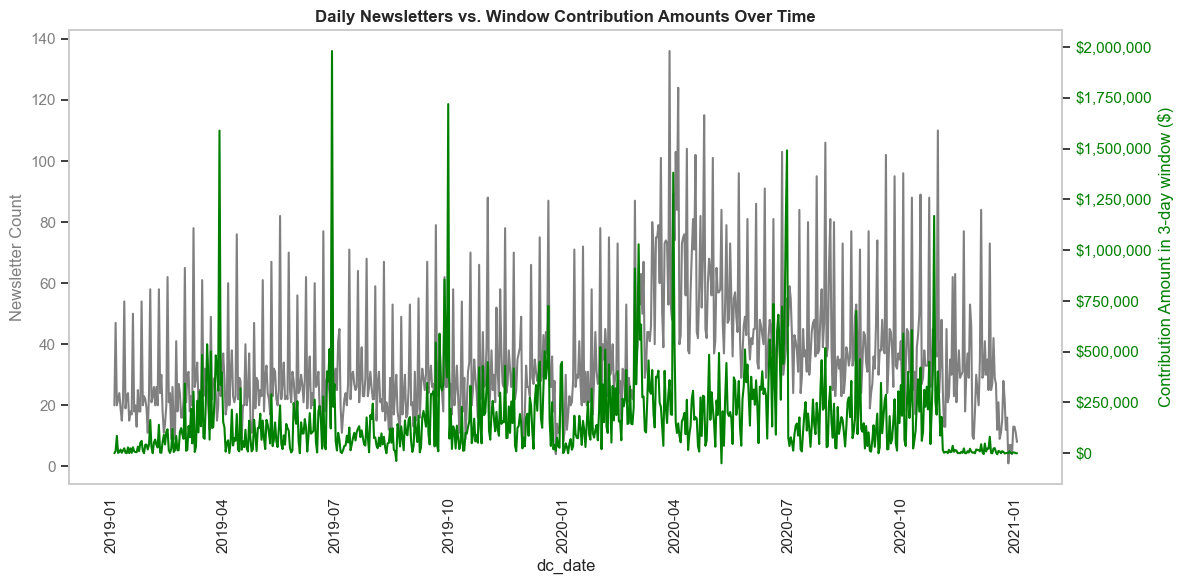

In [ ]:
# --- Create line plot with dual y-axes ---
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot newsletter count (left axis) in gray
sns.lineplot(
    data=daily_df,
    x="dc_date",
    y="newsletter_count",
    ax=ax1,
    color="gray",
    label="Newsletters"
)
ax1.set_ylabel("Newsletter Count", color="gray")
ax1.tick_params(axis='y', labelcolor="gray")

# Rotate x-axis labels 90° on ax1
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, ha="center")

# Create second y-axis for contribution amounts (green)
ax2 = ax1.twinx()
sns.lineplot(
    data=daily_df,
    x="dc_date",
    y="window_contrib_amount",
    ax=ax2,
    color="green",
    label="Contribution Amount (3-day window)"
)
ax2.set_ylabel("Contribution Amount in 3-day window ($)", color="green")
ax2.tick_params(axis='y', labelcolor="green")

# Format right-hand y-axis as dollars
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Bold title
plt.title("Daily Newsletters vs. Window Contribution Amounts Over Time", fontweight="bold")

# Remove legends
ax1.get_legend().remove()
ax2.get_legend().remove()

# Remove gridlines
ax1.grid(False)
ax2.grid(False)

fig.tight_layout()
plt.show()

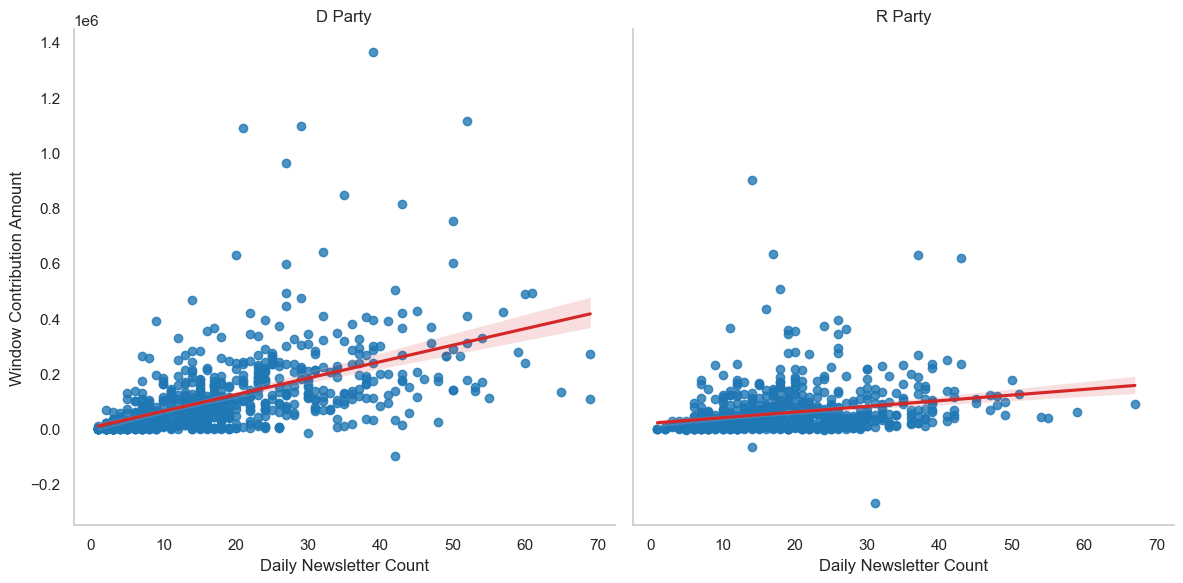

In [ ]:
# Scatterplots of raw newsletter counts and window contribution amounts by party

# Make sure dates are datetime
joined_all_df["dc_date"] = pd.to_datetime(joined_all_df["dc_date"])

# Filter dataframe
# joined_date_filter_df = joined_all_df[joined_all_df["dc_date"].between("2019-11-03", "2020-11-02")]
joined_date_filter_df = joined_all_df[joined_all_df["dc_party"].isin(["D", "R"])]

# Group by day and party
daily_party_df = (
    joined_date_filter_df
    .groupby(["dc_date", "dc_party"], as_index=False)
    .agg({
        "newsletter_count": "sum",
        "window_contrib_amount": "sum"
    })
    .sort_values(["dc_party", "dc_date"])
)

# Create FacetGrid for party
g = sns.FacetGrid(daily_party_df, col="dc_party", height=6, aspect=1)
g.map_dataframe(
    sns.regplot,
    x="newsletter_count",
    y="window_contrib_amount",
    scatter_kws={"color": "tab:blue"},
    line_kws={"color": "tab:red"}
)

# Add titles and labels
g.set_axis_labels("Daily Newsletter Count", "Window Contribution Amount")
g.set_titles(col_template="{col_name} Party")

# Optional: remove gridlines
for ax in g.axes.flat:
    ax.grid(False)

plt.tight_layout()
plt.show()


c:\Users\hefla\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\hefla\AppData\Local\Temp\ipykernel_21380\805539306.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  r_values = agg_df.groupby("dc_party").apply(


Pearson r per party:
 dc_party
D    0.600619
R    0.538752
dtype: float64


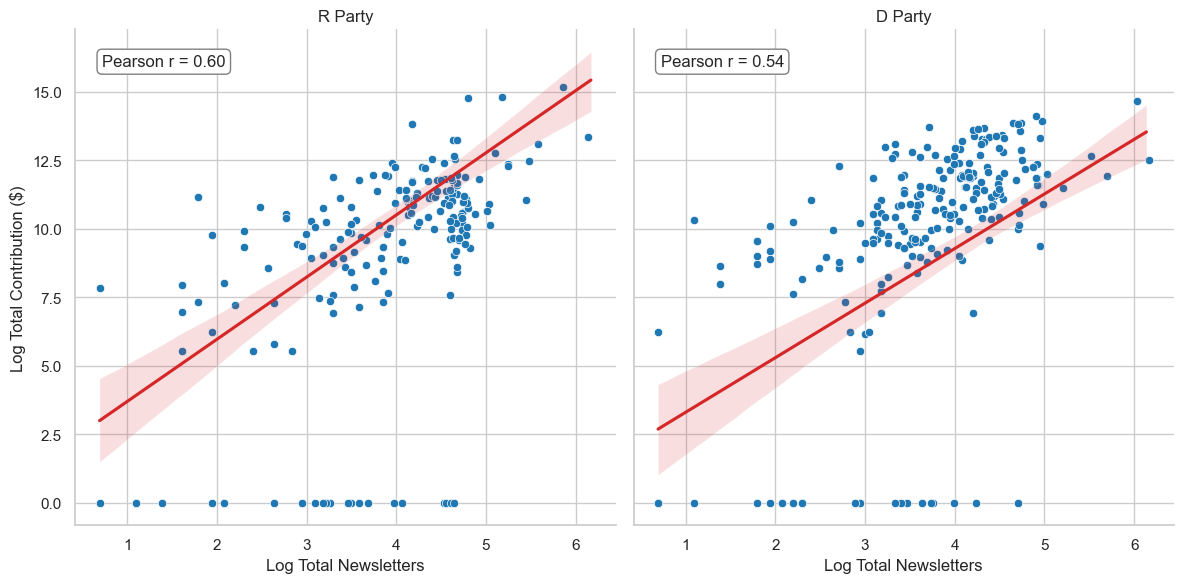

In [ ]:
# Scatterplots of logged contribution amount and logged newsletter count by party

# Aggregate by candidate and party
agg_df = (
    joined_all_df[joined_all_df["dc_party"].isin(["D", "R"])]
    .groupby(["dc_name", "dc_party"], as_index=False)
    .agg({
        "newsletter_count": "sum",
        "contrib_amount": "sum"
    })
)

# Rename for clarity
agg_df = agg_df.rename(columns={
    "newsletter_count": "total_newsletters",
    "contrib_amount": "total_contrib"
})

# Log-transform both contributions and newsletters
agg_df["log_total_contrib"] = np.log1p(agg_df["total_contrib"])  # log(0+1) safe
agg_df["log_total_newsletters"] = np.log1p(agg_df["total_newsletters"])

# Compute Pearson r per party using pandas
r_values = agg_df.groupby("dc_party").apply(
    lambda df: df["log_total_newsletters"].corr(df["log_total_contrib"])
)

print("Pearson r per party:\n", r_values)

# --- Faceted scatterplot with log-transformed axes ---
g = sns.FacetGrid(agg_df, col="dc_party", height=6, aspect=1)
g.map_dataframe(
    sns.scatterplot,
    x="log_total_newsletters",
    y="log_total_contrib",
    color="tab:blue"
)

# Add regression line per facet
for ax, (party, r) in zip(g.axes.flat, r_values.items()):
    sns.regplot(
        data=agg_df[agg_df["dc_party"] == party],
        x="log_total_newsletters",
        y="log_total_contrib",
        scatter=False,
        ax=ax,
        color="tab:red"
    )
    # Annotate Pearson r
    ax.text(
        0.05, 0.95,
        f"Pearson r = {r:.2f}",
        transform=ax.transAxes,
        fontsize=12,
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")
    )

# Labels and titles
g.set_axis_labels("Log Total Newsletters", "Log Total Contribution ($)")
g.set_titles(col_template="{col_name} Party")
plt.tight_layout()
plt.show()


In [ ]:
# Basic deseasoned newsletter bump information

# Set score variable
score = "month_daily_amount_score"

# Ensure date is datetime
joined_score_df["contrib_date"] = pd.to_datetime(joined_score_df["contrib_date"], errors="coerce")

# Filter to relevant columns and keep only D and R
df = joined_score_df[["contrib_date", "dc_party", score]].copy()
df = df[df["dc_party"].isin(["D", "R"])].copy()
df = df[df[score].notna()]
# Remove the one record where score is infinite/NaN 
df[score] = df[score].replace([np.inf, -np.inf], np.nan)

# Create month-year column for grouping
df["month_year"] = df["contrib_date"].dt.to_period("M").dt.to_timestamp()

# Compute monthly average score per party
monthly_avg_score = (
    df.groupby(["month_year", "dc_party"])
      .agg(avg_month_score=(score, "mean"))
      .reset_index()
)

# Overall
overall_avg = monthly_avg_score["avg_month_score"].mean()
overall_median = monthly_avg_score["avg_month_score"].median()

# Democrats
dem_avg = monthly_avg_score.loc[monthly_avg_score["dc_party"] == "D", "avg_month_score"].mean()
dem_median = monthly_avg_score.loc[monthly_avg_score["dc_party"] == "D", "avg_month_score"].median()

# Republicans
rep_avg = monthly_avg_score.loc[monthly_avg_score["dc_party"] == "R", "avg_month_score"].mean()
rep_median = monthly_avg_score.loc[monthly_avg_score["dc_party"] == "R", "avg_month_score"].median()

# Print results
print("Average and Median Newsletter Fundraising Bump (Deseasoned by Month):")
print(f"  • Overall: Average = {overall_avg:.2f}, Median = {overall_median:.2f}")
print(f"  • Democrats: Average = {dem_avg:.2f}, Median = {dem_median:.2f}")
print(f"  • Republicans: Average = {rep_avg:.2f}, Median = {rep_median:.2f}")


Average and Median Newsletter Fundraising Bump (Deseasoned by Month):
  • Overall: Average = 1.64, Median = 1.38
  • Democrats: Average = 1.55, Median = 1.32
  • Republicans: Average = 1.73, Median = 1.54


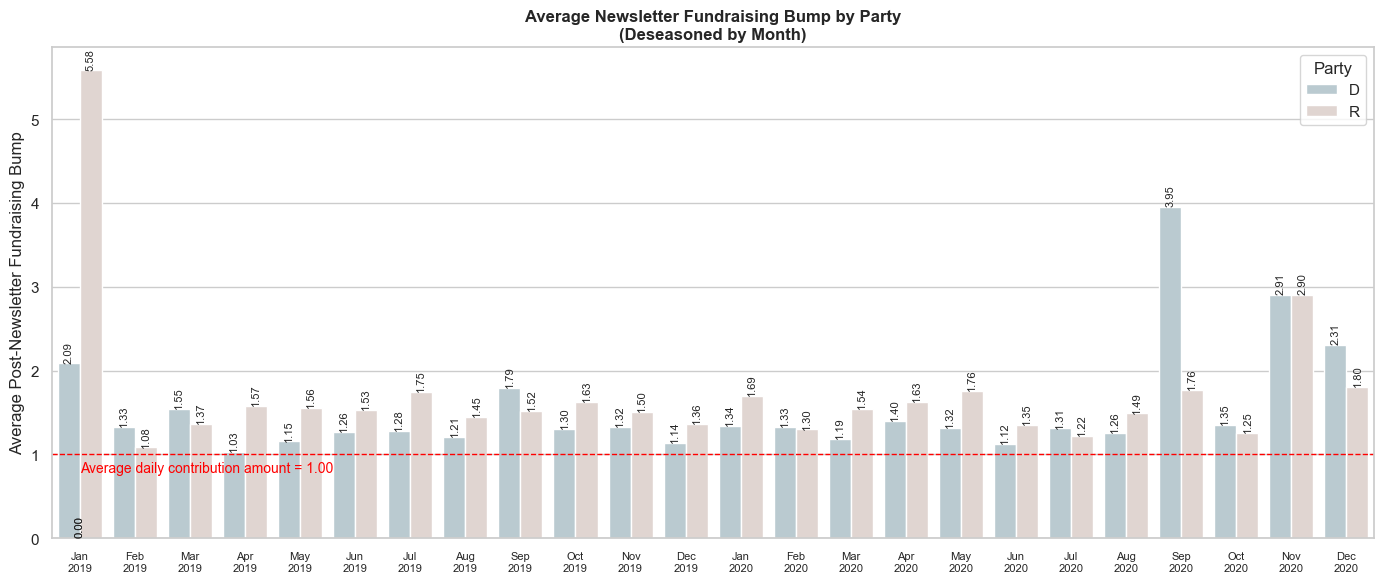

In [ ]:
# Overall deseasoned average bump by party & month

# Set score variable
# score = "avg_daily_fp_amount_score"
# score = "avg_daily_td_amount_score"
score = "month_daily_amount_score"

# Ensure date is datetime
joined_score_df["contrib_date"] = pd.to_datetime(
    joined_score_df["contrib_date"], errors="coerce"
)

# Filter to relevant columns and remove NaNs
df = joined_score_df[["contrib_date", "dc_party", score]].copy()
df = df[df[score].notna()]

# Keep only D and R
df = df[df["dc_party"].isin(["D", "R"])].copy()

# Create a month-year column for grouping
df["month_year"] = df["contrib_date"].dt.to_period("M").dt.to_timestamp()
# df["month_year_str"] = df["month_year"].dt.strftime("%b\n%Y")

# Compute monthly average score per party
monthly_avg_score = (
    df.groupby(["month_year", "dc_party"], dropna=False)
      .agg(avg_month_score=(score, "mean"))
      .reset_index()
)

# Convert month_year to formatted string for x-axis
monthly_avg_score["month_year_str"] = monthly_avg_score["month_year"].dt.strftime("%b\n%Y")

# Set colors
party_colors = {"D": "#B6CCD4", "R": "#E2D4CE"}

# Create the bar plot
plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=monthly_avg_score,
    x="month_year_str",
    y="avg_month_score",
    hue="dc_party",
    palette=party_colors
)

# Red dashed horizontal line at y=1
ax.axhline(y=1, color="red", linestyle="--", linewidth=1)
ax.text(0, 1 - 0.25, "Average daily contribution amount = 1.00", color="red", fontsize=10, va="bottom")

# Add data labels on top of each bar, rotated 90°
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f"{height:.2f}",
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=8
        )

# Format x-axis
plt.xticks(rotation = 0, ha="center", fontsize = 8)
plt.xlabel("")
plt.ylabel("Average Post-Newsletter Fundraising Bump")
plt.title("Average Newsletter Fundraising Bump by Party\n(Deseasoned by Month)", fontweight = "bold")
plt.legend(title="Party")
plt.tight_layout()
plt.show()

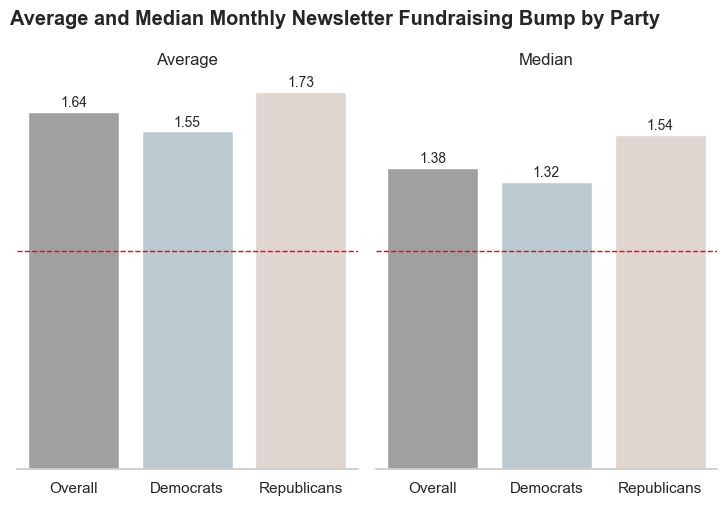

In [ ]:
# Overall deseasoned average & median bump per party

# Make a tidy dataframe for plotting
summary_df = pd.DataFrame({
    "Metric": ["Average", "Average", "Average", "Median", "Median", "Median"],
    "Party": ["Overall", "Democrats", "Republicans"] * 2,
    "Score": [
        overall_avg, dem_avg, rep_avg,
        overall_median, dem_median, rep_median
    ]
})

party_order = ["Overall", "Democrats", "Republicans"]
metric_order = ["Average", "Median"]
party_colors = {"Overall": "#A0A0A0", "Democrats": "#B6CCD4", "Republicans": "#E2D4CE"}

# Create faceted bar plot
g = sns.catplot(
    data=summary_df,
    x="Party",
    y="Score",
    col="Metric",
    kind="bar",
    hue="Party",             # Use hue to assign colors
    palette=party_colors,
    order=party_order,
    col_order=metric_order,
    height=5,
    aspect=0.8,
    legend=False             # Turn off legend
)

# Customize axes
for ax in g.axes.flat:
    # Red dashed line at y=1
    ax.axhline(y=1, color="red", linestyle="--", linewidth=1)
    
    # Remove y-axis ticks, labels, and spine
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    
    # Remove gridlines
    ax.grid(False)
    
    # Add data labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=10
        )

# Titles and labels
g.set_axis_labels("", "")  # remove axis labels
g.set_titles("{col_name}")
g.fig.suptitle("Average and Median Monthly Newsletter Fundraising Bump by Party", fontweight="bold", y=1.05)

plt.show()

In [ ]:
# Funtion for breaking deseasoned average & median bump down by a column

def compute_monthly_score_summary(df, score_col, split_col, parties=["D", "R"], months=True):
    """
    Parameters:
        df (pd.DataFrame): The dataframe containing at least contrib_date, dc_party, split_col, score_col
        score_col (str): The column to compute averages on (e.g., 'month_daily_amount_score')
        split_col (str): The column to break down by (e.g., 'fundraising_terms_used', 'dc_gender', 'body_length', 'year')
        parties (list): List of party values to include (default ['D','R'])
        months (bool): Whether to compute monthly averages before summary (default True)   
        region (str): US Census region for dc_state 
    Returns:
        pd.DataFrame: Summary dataframe with overall, Democrat, and Republican average and median scores per split_col
    """
    
    # Ensure contrib_date is datetime
    df = df.copy()
    df["contrib_date"] = pd.to_datetime(df["contrib_date"], errors="coerce")
    
    # Keep only relevant parties
    df = df[df["dc_party"].isin(parties)]
    
    # Remove missing or infinite scores
    df = df[df[score_col].notna()]
    df[score_col] = df[score_col].replace([np.inf, -np.inf], np.nan)
    
    # Create month-year for grouping if needed
    if months:
        df["month_year"] = df["contrib_date"].dt.to_period("M").dt.to_timestamp()
        group_cols = [split_col, "month_year", "dc_party"]
    else:
        group_cols = [split_col, "dc_party"]
    
    # Compute monthly (or just split_col) average score
    monthly_avg_score = (
        df.groupby(group_cols)
          .agg(avg_month_score=(score_col, "mean"))
          .reset_index()
    )
    
    # Prepare summary list
    summary_list = []
    for val in monthly_avg_score[split_col].unique():
        subset = monthly_avg_score[monthly_avg_score[split_col] == val]
        
        summary_list.append({
            split_col: val,
            "overall_avg": subset["avg_month_score"].mean(),
            "overall_median": subset["avg_month_score"].median(),
            "dem_avg": subset.loc[subset["dc_party"] == "D", "avg_month_score"].mean(),
            "dem_median": subset.loc[subset["dc_party"] == "D", "avg_month_score"].median(),
            "rep_avg": subset.loc[subset["dc_party"] == "R", "avg_month_score"].mean(),
            "rep_median": subset.loc[subset["dc_party"] == "R", "avg_month_score"].median()
        })
    
    return pd.DataFrame(summary_list)


In [199]:
# Create deseasoned bump summary dataframes using breakdown function

# 1. By fundraising_terms_used (boolean)
summary_fundraising = compute_monthly_score_summary(
    joined_score_df, 
    score_col="month_daily_amount_score", 
    split_col="fundraising_terms_used"
)

# 2. By gender (M/F)
summary_gender = compute_monthly_score_summary(
    joined_score_df, 
    score_col="month_daily_amount_score", 
    split_col="dc_gender"
)

# 3. By short/long newsletter
# First create the body_length column if not already done
joined_score_df["body_length"] = joined_score_df["body_word_count_sum"].apply(
    lambda x: "Short" if x < 500 else "Long"
)

summary_length = compute_monthly_score_summary(
    joined_score_df,
    score_col="month_daily_amount_score",
    split_col="body_length"
)

# 4. By year
joined_score_df["year"] = pd.to_datetime(joined_score_df["dc_date"], errors="coerce").dt.year
summary_year = compute_monthly_score_summary(
    joined_score_df,
    score_col="month_daily_amount_score",
    split_col="year"
)

# 5. By US Census region
summary_region = compute_monthly_score_summary(
    joined_score_df,
    score_col="month_daily_amount_score",
    split_col="census_region"
)

# 6. By state
summary_state = compute_monthly_score_summary(
    joined_score_df,
    score_col="month_daily_amount_score",
    split_col="dc_state"
)

# summary_gender.head()
# summary_year.head()
# summary_length.head()
# summary_fundraising.head()
# summary_state.head()
summary_region.head()

,census_region,overall_avg,overall_median,dem_avg,dem_median,rep_avg,rep_median
0,Midwest,2.142878,1.475136,2.436243,1.280992,1.849513,1.637999
1,Northeast,1.366940,1.300928,1.285770,1.181663,1.448111,1.352412
2,South,1.755463,1.410365,1.587720,1.329707,1.923207,1.524458
3,West,1.430833,1.326007,1.428587,1.335612,1.433080,1.284503


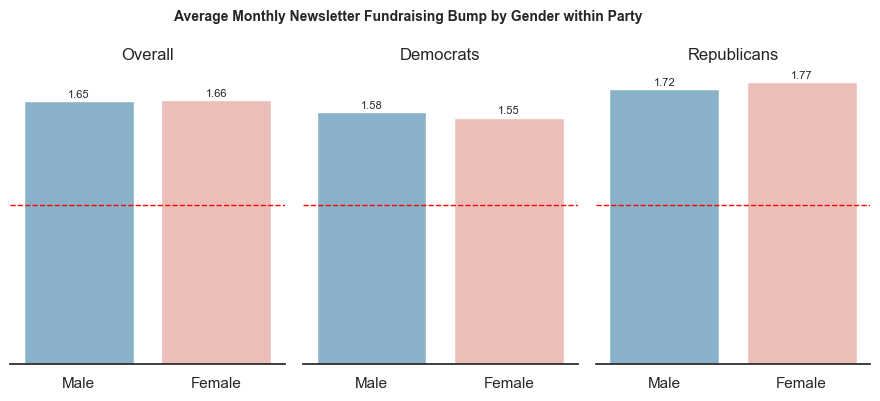

In [ ]:
# Plot deseasoned average bumps by gender & party

# Make a tidy dataframe for plotting: Gender as x, Party as facet
summary_gender_plot = pd.DataFrame({
    "Gender": ["Male", "Female"] * 3,  # map M/F to Male/Female
    "Score": [
        summary_gender.loc[summary_gender["dc_gender"] == "M", "overall_avg"].values[0],
        summary_gender.loc[summary_gender["dc_gender"] == "F", "overall_avg"].values[0],
        summary_gender.loc[summary_gender["dc_gender"] == "M", "dem_avg"].values[0],
        summary_gender.loc[summary_gender["dc_gender"] == "F", "dem_avg"].values[0],
        summary_gender.loc[summary_gender["dc_gender"] == "M", "rep_avg"].values[0],
        summary_gender.loc[summary_gender["dc_gender"] == "F", "rep_avg"].values[0]
    ],
    "Party": ["Overall"] * 2 + ["Democrats"] * 2 + ["Republicans"] * 2
})

# Define gender order and party colors
gender_order = ["Male", "Female"]
party_colors = {"Overall": "#A0A0A0", "Democrats": "#B6CCD4", "Republicans": "#E2D4CE"}

# Create smaller faceted bar plot: facet by Party, x = Gender
g = sns.catplot(
    data=summary_gender_plot,
    x="Gender",
    y="Score",
    col="Party",
    kind="bar",
    hue="Gender",  # colors by gender
    palette={"Male": "#7FB3D5", "Female": "#F5B7B1"},
    order=gender_order,
    height=4,  
    aspect=0.8,
    legend=False
)

# Customize axes
for ax in g.axes.flat:
    # Red dashed line at y=1
    ax.axhline(y=1, color="red", linestyle="--", linewidth=1)
    
    # Remove y-axis ticks, labels, and spine
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    
    # Remove gridlines
    ax.grid(False)
    
    # Add data labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8  # slightly smaller font for smaller plot
        )

# Titles and labels
g.set_axis_labels("", "")  # remove axis labels
g.set_titles("{col_name}")  # facet titles = Party
g.fig.suptitle("Average Monthly Newsletter Fundraising Bump by Gender", 
               fontweight="bold", y=1.05, fontsize=10)

plt.show()

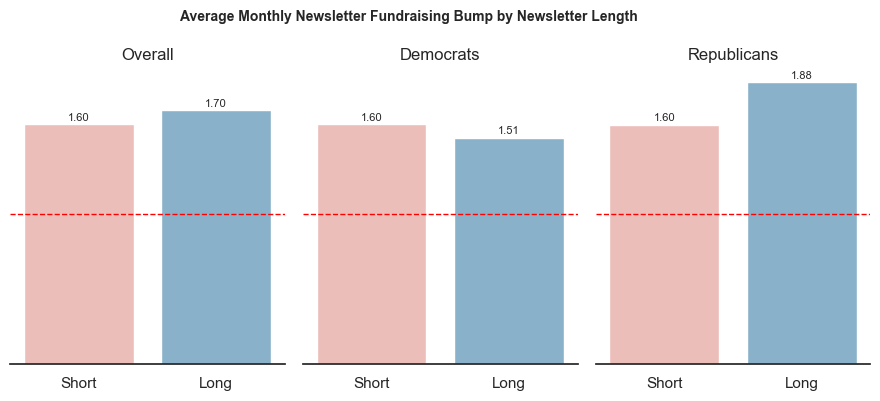

In [ ]:
# Plot deseasoned average bumps by newsletter length & party

# Make a tidy dataframe for plotting: body_length as x, Party as facet
summary_length_plot = pd.DataFrame({
    "Newsletter Length": ["Short", "Long"] * 3,
    "Score": [
        summary_length.loc[summary_length["body_length"] == "Short", "overall_avg"].values[0],
        summary_length.loc[summary_length["body_length"] == "Long", "overall_avg"].values[0],
        summary_length.loc[summary_length["body_length"] == "Short", "dem_avg"].values[0],
        summary_length.loc[summary_length["body_length"] == "Long", "dem_avg"].values[0],
        summary_length.loc[summary_length["body_length"] == "Short", "rep_avg"].values[0],
        summary_length.loc[summary_length["body_length"] == "Long", "rep_avg"].values[0]
    ],
    "Party": ["Overall"] * 2 + ["Democrats"] * 2 + ["Republicans"] * 2
})

# Define order and colors
length_order = ["Short", "Long"]
party_colors = {"Overall": "#A0A0A0", "Democrats": "#B6CCD4", "Republicans": "#E2D4CE"}
length_colors = {"Short": "#F5B7B1", "Long": "#7FB3D5"}

# Create smaller faceted bar plot: facet by Party, x = Newsletter Length
g = sns.catplot(
    data=summary_length_plot,
    x="Newsletter Length",
    y="Score",
    col="Party",
    kind="bar",
    hue="Newsletter Length",  # colors by length
    palette=length_colors,
    order=length_order,
    height=4,  
    aspect=0.8,
    legend=False
)

# Customize axes
for ax in g.axes.flat:
    # Red dashed line at y=1
    ax.axhline(y=1, color="red", linestyle="--", linewidth=1)
    
    # Remove y-axis ticks, labels, and spine
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    
    # Remove gridlines
    ax.grid(False)
    
    # Add data labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

# Titles and labels
g.set_axis_labels("", "")
g.set_titles("{col_name}")  # facet titles = Party
g.fig.suptitle("Average Monthly Newsletter Fundraising Bump by Newsletter Length", 
               fontweight="bold", y=1.05, fontsize=10)

plt.show()


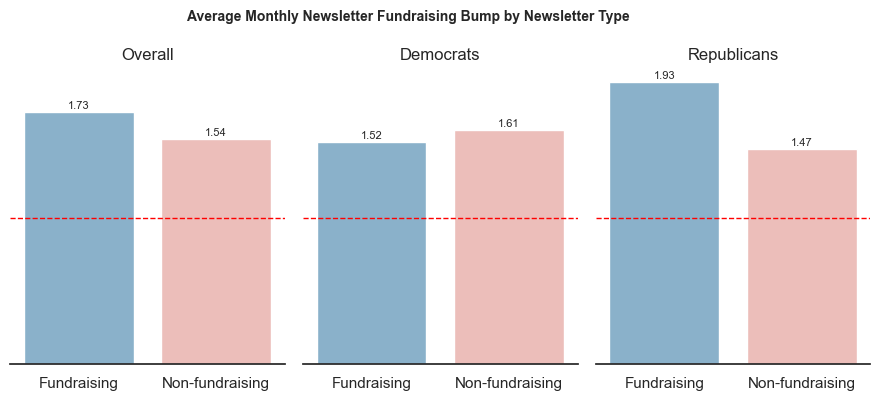

In [ ]:
# Plot deseasoned average bumps by fundraising terms & party

# Make a tidy dataframe for plotting: fundraising_terms_used as x, Party as facet
summary_fundraising_plot = pd.DataFrame({
    "Newsletter Type": ["Fundraising", "Non-fundraising"] * 3,
    "Score": [
        summary_fundraising.loc[summary_fundraising["fundraising_terms_used"] == True, "overall_avg"].values[0],
        summary_fundraising.loc[summary_fundraising["fundraising_terms_used"] == False, "overall_avg"].values[0],
        summary_fundraising.loc[summary_fundraising["fundraising_terms_used"] == True, "dem_avg"].values[0],
        summary_fundraising.loc[summary_fundraising["fundraising_terms_used"] == False, "dem_avg"].values[0],
        summary_fundraising.loc[summary_fundraising["fundraising_terms_used"] == True, "rep_avg"].values[0],
        summary_fundraising.loc[summary_fundraising["fundraising_terms_used"] == False, "rep_avg"].values[0]
    ],
    "Party": ["Overall"] * 2 + ["Democrats"] * 2 + ["Republicans"] * 2
})

# Define order and colors
newsletter_order = ["Fundraising", "Non-fundraising"]
newsletter_colors = {"Fundraising": "#7FB3D5", "Non-fundraising": "#F5B7B1"}

# Create smaller faceted bar plot: facet by Party, x = Newsletter Type
g = sns.catplot(
    data=summary_fundraising_plot,
    x="Newsletter Type",
    y="Score",
    col="Party",
    kind="bar",
    hue="Newsletter Type",  # colors by type
    palette=newsletter_colors,
    order=newsletter_order,
    height=4,  
    aspect=0.8,
    legend=False
)

# Customize axes
for ax in g.axes.flat:
    # Red dashed line at y=1
    ax.axhline(y=1, color="red", linestyle="--", linewidth=1)
    
    # Remove y-axis ticks, labels, and spine
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    
    # Remove gridlines
    ax.grid(False)
    
    # Add data labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

# Titles and labels
g.set_axis_labels("", "")
g.set_titles("{col_name}")  # facet titles = Party
g.fig.suptitle("Average Monthly Newsletter Fundraising Bump by Newsletter Type", 
               fontweight="bold", y=1.05, fontsize=10)

plt.show()

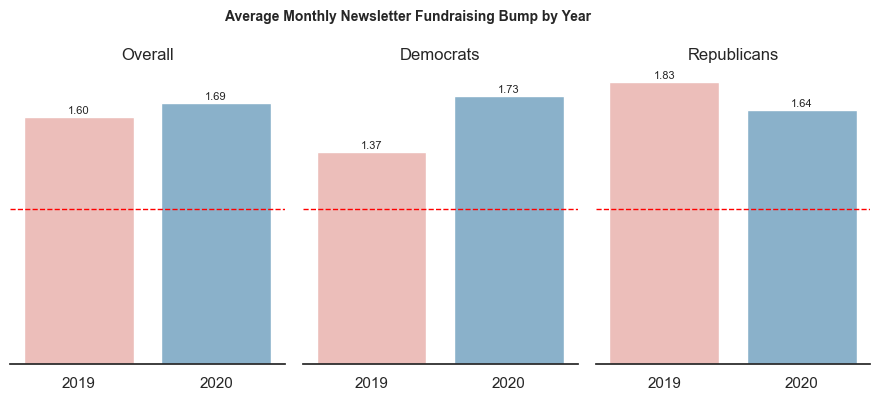

In [ ]:
# Plot deseasoned average bumps by year & party

# Make a tidy dataframe for plotting: year as x, Party as facet
summary_year_plot = pd.DataFrame({
    "Year": [2019, 2020] * 3,
    "Score": [
        summary_year.loc[summary_year["year"] == 2019, "overall_avg"].values[0],
        summary_year.loc[summary_year["year"] == 2020, "overall_avg"].values[0],
        summary_year.loc[summary_year["year"] == 2019, "dem_avg"].values[0],
        summary_year.loc[summary_year["year"] == 2020, "dem_avg"].values[0],
        summary_year.loc[summary_year["year"] == 2019, "rep_avg"].values[0],
        summary_year.loc[summary_year["year"] == 2020, "rep_avg"].values[0]
    ],
    "Party": ["Overall"] * 2 + ["Democrats"] * 2 + ["Republicans"] * 2
})

# Define order and colors
year_order = [2019, 2020]
year_colors = {2019: "#F5B7B1", 2020: "#7FB3D5"}

# Create smaller faceted bar plot: facet by Party, x = Year
g = sns.catplot(
    data=summary_year_plot,
    x="Year",
    y="Score",
    col="Party",
    kind="bar",
    hue="Year",  # colors by year
    palette=year_colors,
    order=year_order,
    height=4,  
    aspect=0.8,
    legend=False
)

# Customize axes
for ax in g.axes.flat:
    # Red dashed line at y=1
    ax.axhline(y=1, color="red", linestyle="--", linewidth=1)
    
    # Remove y-axis ticks, labels, and spine
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    
    # Remove gridlines
    ax.grid(False)
    
    # Add data labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

# Titles and labels
g.set_axis_labels("", "")
g.set_titles("{col_name}")  # facet titles = Party
g.fig.suptitle("Average Monthly Newsletter Fundraising Bump by Year", 
               fontweight="bold", y=1.05, fontsize=10)

plt.show()


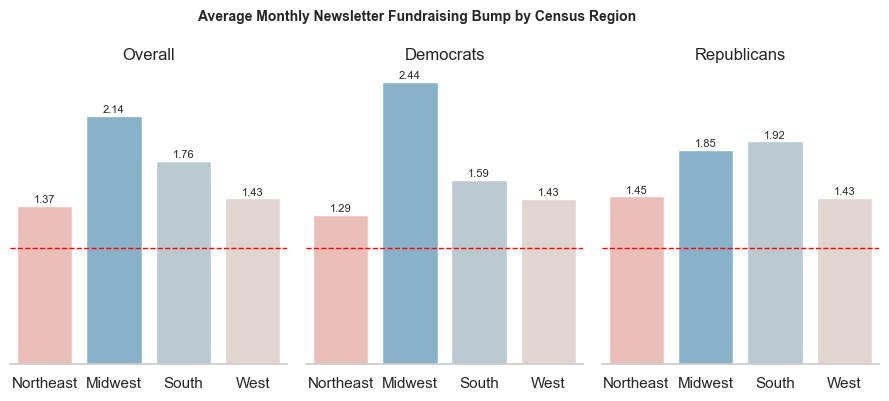

In [188]:
# Plot deseasoned average bumps by census region & party

# Make a tidy dataframe for plotting: census_region as x, Party as facet
summary_region_plot = pd.DataFrame({
    "Census Region": ["Northeast", "Midwest", "South", "West"] * 3,
    "Score": [
        summary_region.loc[summary_region["census_region"] == "Northeast", "overall_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "Midwest", "overall_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "South", "overall_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "West", "overall_avg"].values[0],
        
        summary_region.loc[summary_region["census_region"] == "Northeast", "dem_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "Midwest", "dem_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "South", "dem_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "West", "dem_avg"].values[0],
        
        summary_region.loc[summary_region["census_region"] == "Northeast", "rep_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "Midwest", "rep_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "South", "rep_avg"].values[0],
        summary_region.loc[summary_region["census_region"] == "West", "rep_avg"].values[0]
    ],
    "Party": ["Overall"] * 4 + ["Democrats"] * 4 + ["Republicans"] * 4
})

# Define order and colors
region_order = ["Northeast", "Midwest", "South", "West"]
region_colors = {
    "Northeast": "#F5B7B1",
    "Midwest": "#7FB3D5",
    "South": "#B6CCD4",
    "West": "#E2D4CE"
}

# Create smaller faceted bar plot: facet by Party, x = Census Region
g = sns.catplot(
    data=summary_region_plot,
    x="Census Region",
    y="Score",
    col="Party",
    kind="bar",
    hue="Census Region",  # colors by region
    palette=region_colors,
    order=region_order,
    height=4,
    aspect=0.8,
    legend=False
)

# Customize axes
for ax in g.axes.flat:
    # Red dashed line at y=1
    ax.axhline(y=1, color="red", linestyle="--", linewidth=1)
    
    # Remove y-axis ticks, labels, and spine
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    
    # Remove gridlines
    ax.grid(False)
    
    # Add data labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=height + 0.01,
            s=f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

# Titles and labels
g.set_axis_labels("", "")
g.set_titles("{col_name}")  # facet titles = Party
g.fig.suptitle("Average Monthly Newsletter Fundraising Bump by Census Region", 
               fontweight="bold", y=1.05, fontsize=10)

plt.show()


year                                                          2019.0  \
dc_party                                                           D   
dc_gender body_length fundraising_terms_used census_region             
F         Long        False                  Midwest        1.713792   
                                             Northeast      1.036288   
                                             South          1.164683   
                                             West           1.140015   
                      True                   Midwest        1.395196   

year                                                                  \
dc_party                                                           R   
dc_gender body_length fundraising_terms_used census_region             
F         Long        False                  Midwest        0.637500   
                                             Northeast      0.170000   
                                             South          3.5

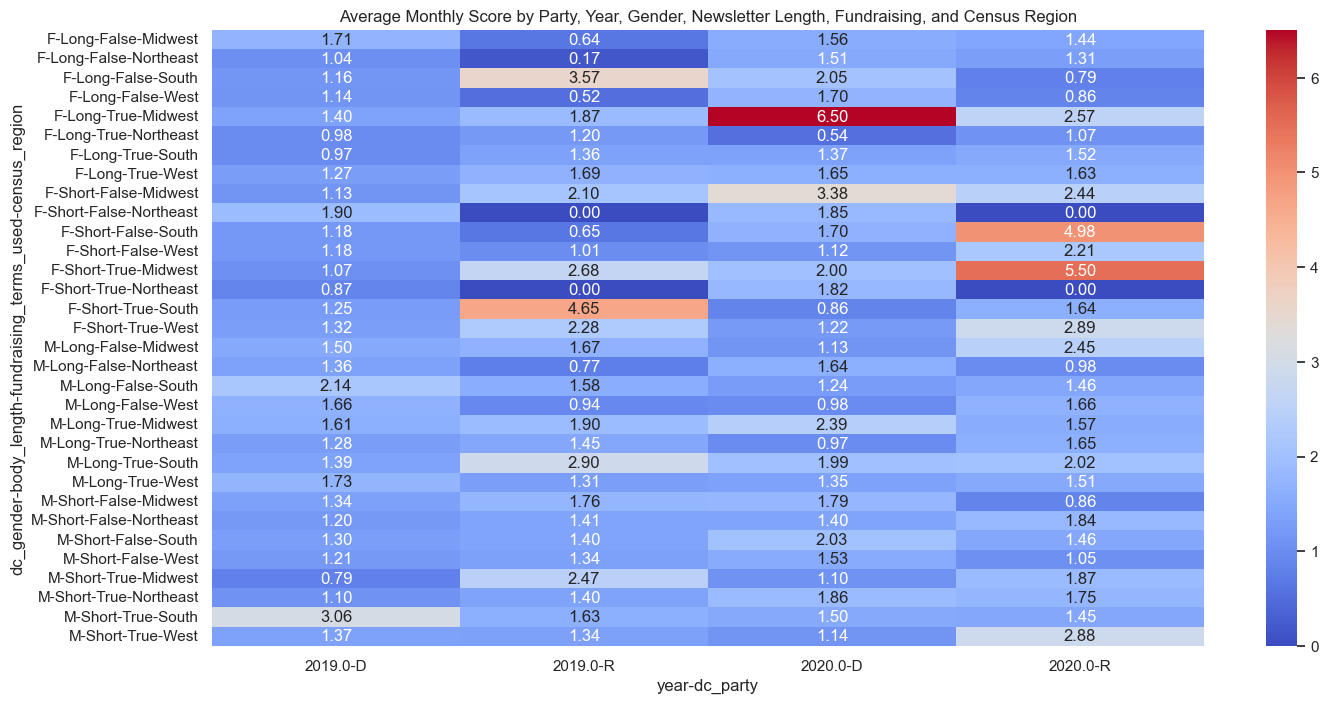

In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def compute_multidim_summary(df, score_col="month_daily_amount_score"):
    """
    Computes monthly averages and overall averages per combination of party, year, gender, newsletter length,
    fundraising terms, and census region, and returns a pivot table for easy visualization.
    """
    
    df = df.copy()
    
    # Ensure necessary columns exist
    df["dc_party"] = df["dc_party"].astype(str)
    df["contrib_date"] = pd.to_datetime(df["contrib_date"], errors="coerce")
    df["year"] = df["contrib_date"].dt.year
    df["fundraising_terms_used"] = df["fundraising_terms_sum"] > 0
    df["body_length"] = np.where(df["body_word_count_sum"] < 500, "Short", "Long")
    
    # Filter for relevant parties
    df = df[df["dc_party"].isin(["D", "R"])]
    
    # Remove missing or infinite scores
    df = df[df[score_col].notna()]
    df[score_col] = df[score_col].replace([np.inf, -np.inf], np.nan)
    
    # Create month-year for monthly aggregation
    df["month_year"] = df["contrib_date"].dt.to_period("M").dt.to_timestamp()
    
    # Define categorical columns for breakdown
    categorical_cols = ["dc_gender", "body_length", "fundraising_terms_used", "census_region"]
    
    # Compute monthly average scores
    monthly_avg_score = (
        df.groupby(["dc_party", "year", "month_year"] + categorical_cols)
          .agg(avg_month_score=(score_col, "mean"))
          .reset_index()
    )
    
    # Collapse months to get overall average per combination
    summary = (
        monthly_avg_score
        .groupby(["dc_party", "year"] + categorical_cols)
        .agg(overall_avg=("avg_month_score", "mean"),
             overall_median=("avg_month_score", "median"))
        .reset_index()
    )
    
    # Create pivot table: index = gender, length, fundraising, region; columns = party × year
    pivot_table = summary.pivot_table(
        index=categorical_cols,
        columns=["year", "dc_party"],
        values="overall_avg"
    )
    
    return summary, pivot_table

# ----------------------------
# Usage example:

summary_df, pivot_df = compute_multidim_summary(joined_all_df)

# Inspect the pivot table
print(pivot_df.head())

# Optional: Heatmap for visualization
plt.figure(figsize=(16, 8))
sns.heatmap(pivot_df.fillna(0), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Average Monthly Score by Party, Year, Gender, Newsletter Length, Fundraising, and Census Region")
plt.show()


In [209]:
# List of continental US states (two-letter codes)
continental_states = [
    'AL','AR','AZ','CA','CO','CT','DE','FL','GA','IA','ID','IL','IN','KS','KY','LA',
    'MA','MD','ME','MI','MN','MO','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY',
    'OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VA','VT','WA','WI','WV','WY'
]

# Filter dataframe to continental US only
summary_state_continental = summary_state[summary_state['dc_state'].isin(continental_states)]

# Create side-by-side choropleth maps
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Democrats", "Republicans"),
    specs=[[{"type": "choropleth"}, {"type": "choropleth"}]]
)

# Democratic map
fig.add_trace(
    go.Choropleth(
        locations=summary_state_continental['dc_state'],
        z=summary_state_continental['dem_avg'],
        locationmode='USA-states',
        colorscale='Blues',
        showscale=False  # remove colorbar
    ),
    row=1, col=1
)

# Republican map
fig.add_trace(
    go.Choropleth(
        locations=summary_state_continental['dc_state'],
        z=summary_state_continental['rep_avg'],
        locationmode='USA-states',
        colorscale='Reds',
        showscale=False  # remove colorbar
    ),
    row=1, col=2
)

# Update layout for continental US on both maps
fig.update_geos(scope='usa', row=1, col=1)
fig.update_geos(scope='usa', row=1, col=2)

# Remove interactivity (disable hover, zoom, pan)
fig.update_layout(
    title_text="Average Monthly Newsletter Fundraising Bump by State and Party (Continental US Only)",
    height=500,
    width=1000,
    hovermode=False
)

fig.show()